In [3]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt


In [4]:
def optimize_2links(m, a, b, lr=0.01, I_cost_def=None, n_iter=1000, show_plot=True, show_surface=True, u0=[-.9, -0.9], elev=30, azim=45, roll=0):
    '''
        Solves a 2-parallel link user-optimum traffic assignment problem with affine delay function, tau,
                          and variable intervention u on the linear coefficients of tau using gradient descent
        Inputs:
               - m: throughput
               - a: linear coefficients of the delay function
               - b: constants of the delay functions
               - lr: learning rate
               - I_cost_def: dictionary with all information about Intervention Cost (cost, derivative, alpha, name)
               - n_iter: number of iterations of the gradient descent algorithm
               - show_plot: if True, shows how Total Cost, Link Flows and u change with each iteration
               - show_surface: if True, plots the surface of the Total Cost with u1 and u2, and the path that the optimization took
               - u0 = intervention initialization
               - elev, azim, roll: angles for the surface plot. Will be ignored if show_surface is False
    '''

    # Extracting Internvetion Cost information
    if I_cost_def==None or  I_cost_def['alpha']==0:
        I_cost = lambda u: 0
        dI_cost = lambda u: 0
        I_cost_name = 'No Intervention'
        alpha = 0        
    else:
        I_cost = I_cost_def['I_cost']
        dI_cost = I_cost_def['dI_cost']
        alpha = I_cost_def['alpha']
        I_cost_name = I_cost_def['I_cost_name']
    
    # Initializing interventions u
    u = u0

    # Social Cost and its derivative
    Ce = lambda f, tau: f*tau
    dCe = lambda f, u, a: -a*(f**2)/(1+u) # derivative of C w.r.t ue
    
    # Delay function and its integral, which will be used in the Wardrop function
    tau = lambda a, b, f, u: a*f/(1+u) + b # delay function
    integral_tau_wrt_f = lambda a, b, f, u: 0.5*(a*(f**2))/(1+u) + b*f
    
    # Wardrop function: for a given f sum over integral of tau(f)
    def wardrop(f):
        s = 0
        for i in range(2):
            s += integral_tau_wrt_f(a[i], b[i], f[i], u[i])
        return s
    
    # Defining Constraints for the Wardrop Minimization
    def conservation_of_mass(f):
        return np.dot(B, f) - v
    
    constraint = ({'type': 'eq', 'fun': lambda f: conservation_of_mass(f)},
                  {'type': 'ineq', 'fun': lambda f: f[0]},
                  {'type': 'ineq', 'fun': lambda f: f[1]},)

    v = m*np.array([1])
    B = np.array([[1,1]])
    
    # Optimization
    T_values = []
    u_values = []
    f_values = []
    
    for _ in range(int(n_iter)):
        
        # Calculate Wardrop equilibrium for u
        result = minimize(wardrop, x0=[0,1], constraints=constraint)
        if not result.success:
            print('Error')
            break
        f_eq = result.x
        f_values.append(f_eq) 

        # Update u given f_eq
        dI = np.array([dI_cost(u[i]) for i in range(2)])
        dC = np.array([dCe(f_eq[i],u[i],a[i]) for i in range(2)])
        dT = dC + alpha*dI
        du = -lr*dT
        T_values.append(np.sum([f_eq[i]*tau(a[i], b[i], f_eq[i], u[i]) + alpha*I_cost(u[i]) for i in range(2)]))
        u_values.append(u)
        if min(u + du) < -1:
            break
        u = u + du
    best_u = u
    
    # Plotting Results
    u_values = np.array(u_values)
        
    if show_surface:
        u_min = u_values.min()
        u_max = u_values.max()
        possible_us = np.linspace(-0.9, 3, 40)
        
        u_grid = []
        T_grid = []
        for ux in possible_us:
            for uy in possible_us:
                u = [ux, uy]
                # Calculate Wardrop equilibrium for u
                result = minimize(wardrop, x0=[1,1], constraints=constraint, bounds=[(0,None), (0,None)])
                f_eq = result.x

                # Update u given f_eq
                T_grid.append(np.sum([f_eq[i]*tau(a[i], b[i], f_eq[i], u[i]) + alpha*I_cost(u[i]) for i in range(2)]))
                u_grid.append(u)

        u1_grid = [i[0] for i in u_grid]
        u2_grid = [i[1] for i in u_grid]
        
        fig, ax = plt.subplots(1, 1, figsize=(5, 4))
        if alpha==0:
            fig.suptitle(f'No Intervention Cost, a={a}, b={b}')
        else:
            fig.suptitle(f'Intervention Cost = {I_cost_name}, alpha={alpha}, a={a}, b={b}')
        ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax = fig.add_subplot(111,  projection='3d')
        ax.view_init(elev=elev, azim=azim, roll=roll)
        ax.scatter(u1_grid, u2_grid, T_grid, s=7, c='orange', label='Total Cost', alpha=0.4)
        ax.plot(u_values[:,0], u_values[:,1], T_values, c='red')
        ax.set_xlabel('u1')
        ax.set_ylabel('u2')
        ax.set_zlabel('Total Cost')
        ax.legend()
        plt.show()
            
    if show_plot:
        fig, ax = plt.subplots(1, 3, figsize=(20, 4))
        ax[0].set_title(f'Total Cost vs Iteration a={round(a[0],2), round(a[1],2)}, b={round(b[0],2), round(b[1],2)}')
        ax[0].set_ylabel('Total Cost = Social Cost + Intervention Cost')
        ax[0].set_xlabel('Iteration')
        ax[0].plot(T_values)

        ax[1].set_title('Intervention Values vs Iteration')
        ax[1].set_ylabel('Intervention Values')
        ax[1].set_xlabel('Iteration')
        ax[1].plot(u_values, label=['u1', 'u2'])
        ax[1].legend()

        ax[2].set_title('Edge Flow vs Iteration')
        ax[2].set_ylabel('Edge Flow')
        ax[2].set_xlabel('Iteration')
        ax[2].plot(f_values, label=['f1', 'f2'])
        ax[2].set_ylim(-0.01,1.05)
        ax[2].legend()
    
    return best_u

In [5]:
def sketch_cost(m, a, b, alpha=None, I_cost_def=None, show_plot=True, n_levels=5):
    
    if I_cost_def==None or  I_cost_def['alpha']==0:
        I_cost = lambda u: 0
        alpha = 0        
    else:
        I_cost = I_cost_def['I_cost']
        alpha = I_cost_def['alpha']
        I_cost_name = I_cost_def['I_cost_name']
        
    tau = lambda a, b, f, u: a*f/(1+u) + b # delay function
    integral_tau_wrt_f = lambda a, b, f, u: 0.5*(a*(f**2))/(1+u) + b*f

    def wardrop(f):
        s = 0
        for i in range(2):
            s += integral_tau_wrt_f(a[i], b[i], f[i], u[i])
        return s

    def conservation_of_mass(f):
        return np.dot(B, f) - v
    
    constraint = ({'type': 'eq', 'fun': lambda f: conservation_of_mass(f)},
                  {'type': 'ineq', 'fun': lambda f: f[0]},
                  {'type': 'ineq', 'fun': lambda f: f[1]},)
    
    v = m*np.array([1])
    B = np.array([[1,1]])
        
    possible_us = np.linspace(-0.9, 3, 40)
    u_values = []
    T_values = []
    f1_values = []
    f2_values = []
    for ux in possible_us:
        for uy in possible_us:
            u = [ux, uy]
            # Calculate Wardrop equilibrium for u
            result = minimize(wardrop, x0=[1,1], constraints=constraint)
            f_eq = result.x
            f1_values.append(f_eq[0])
            f2_values.append(f_eq[1])

            # Update u given f_eq
            T_values.append(np.sum([f_eq[i]*tau(a[i], b[i], f_eq[i], u[i]) + alpha*I_cost(u[i]) for i in range(2)]))
            u_values.append(u)
    
    u1 = [i[0] for i in u_values]
    u2 = [i[1] for i in u_values]
    u_values = np.array(u_values)
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    if alpha==0:
        fig.suptitle(f'No Intervention Cost, a={a}, b={b}')
    else:
        fig.suptitle(f'Intervention Cost = {I_cost_name}, alpha={alpha}, a={a}, b={b}')
    ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(111,  projection='3d')
    ax.view_init(elev=30, azim=45, roll=0)
    ax.scatter(u1, u2, T_values, s=7, c='orange', label='Total Cost')
    ax.set_xlabel('u1')
    ax.set_ylabel('u2')
    ax.set_zlabel('Total Cost')
    ax.legend()
    plt.show()
    
    T_levels = np.linspace(min(T_values), max(T_values), n_levels+1)[1:]
    
    fig, ax = plt.subplots(1, n_levels, figsize=(20, 4))

    for k, T_level in enumerate(T_levels):
        u_set = u_values[T_values <= T_level,:]
        ax[k].scatter(u_set[:,0], u_set[:,1], s=1)
        ax[k].set_xlim(-1,3)
        ax[k].set_ylim(-1,3)
        ax[k].set_xlabel('u1')
        ax[k].set_ylabel('u2')
        ax[k].set_title(f'Sublevel set for K={round(T_level,2)}')
    plt.tight_layout()
    plt.show()
    
    return u1, u2, T_values

# No Intervention

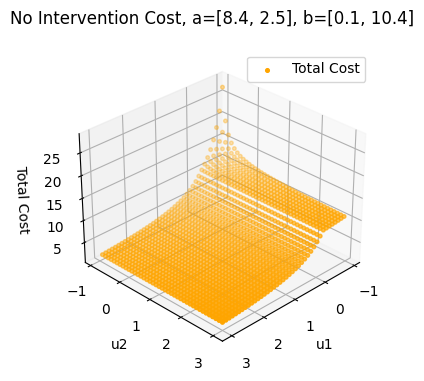

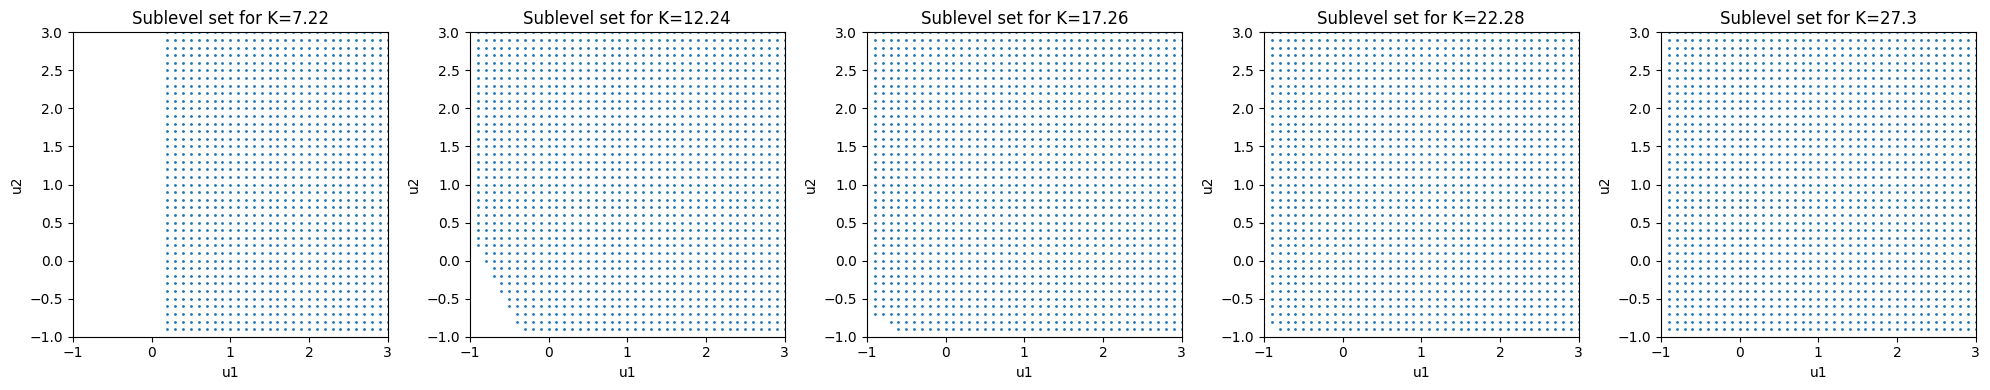

In [8]:
u1, u2, T = sketch_cost(m=1, a=[8.4, 2.5], b=[0.1, 10.4], n_levels=5)

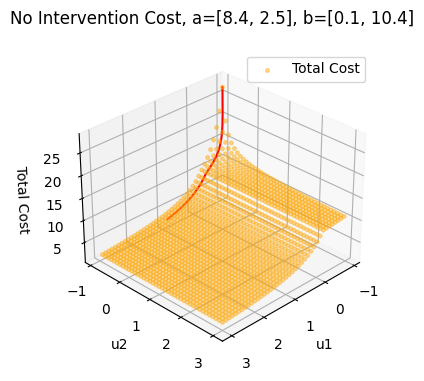

Optimal u=[ 1.09177704 -0.7365707 ]


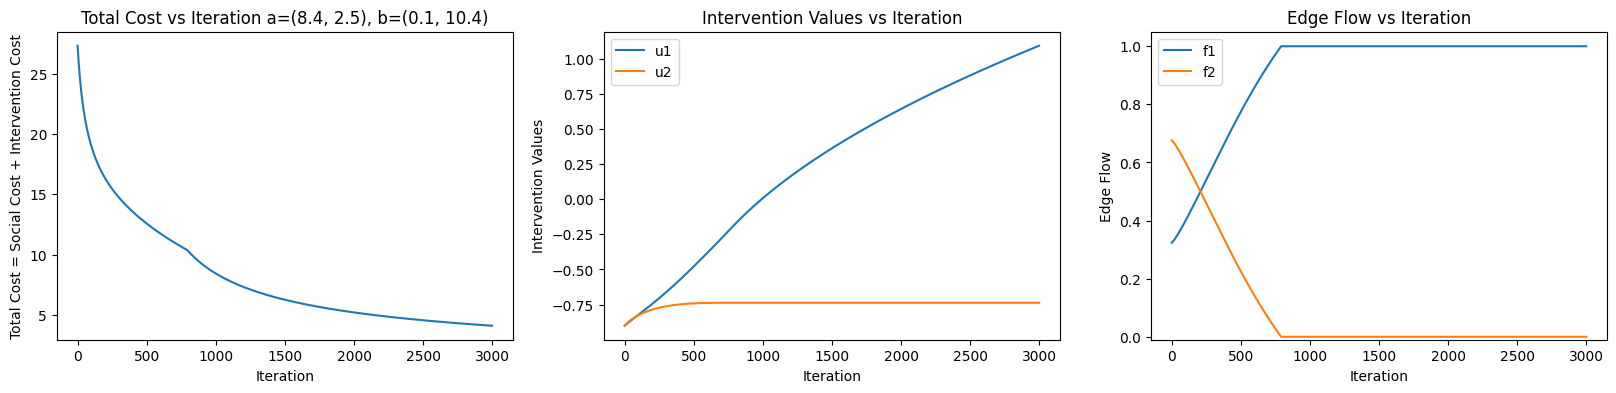

In [7]:
best_u = optimize_2links(m=1, a=[8.4, 2.5], b=[0.1, 10.4], lr=0.0001, n_iter=3e3)
print(f'Optimal u={best_u}')

# Linear Intervention Cost, alpha=0.5

In [14]:
I_cost_def = {'I_cost': lambda u: u,
              'dI_cost': lambda u: 1,
              'alpha': 0.5, 
              'I_cost_name': 'Linear'}

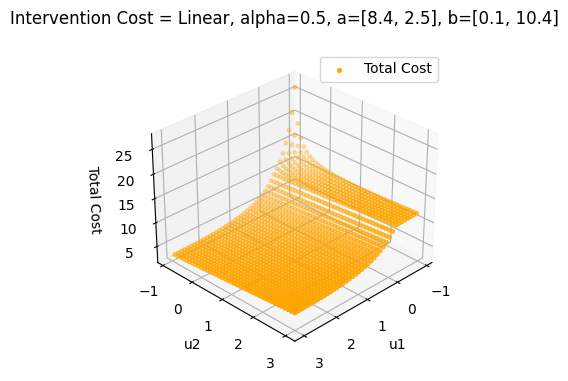

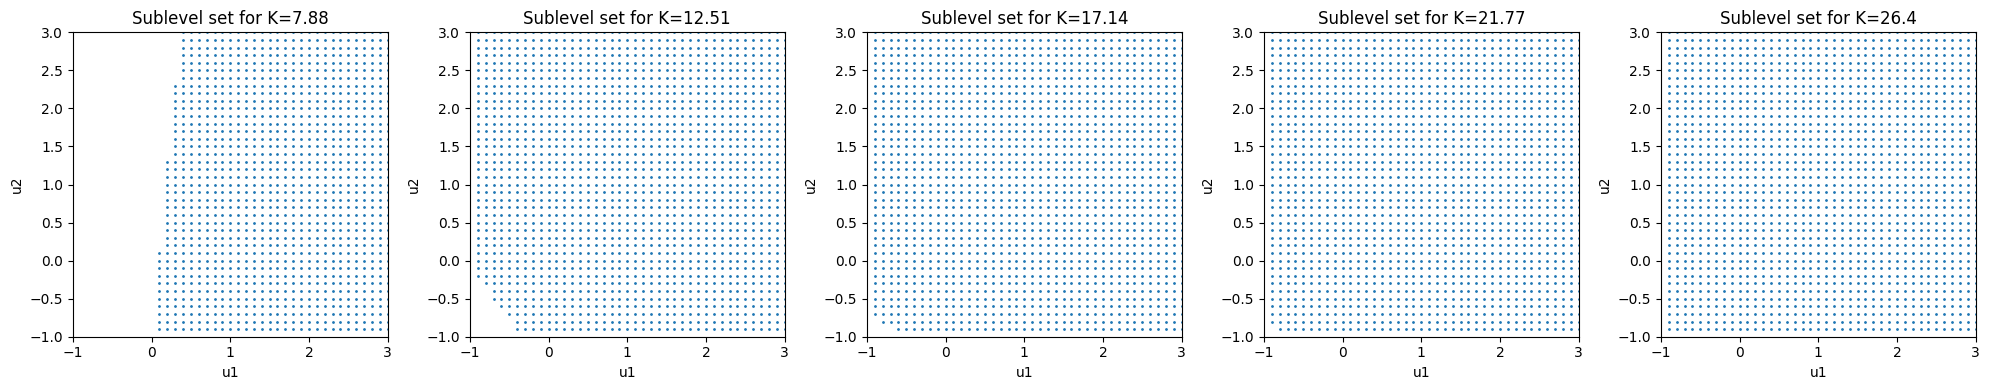

In [15]:
u1, u2, T = sketch_cost(m=1, a=[8.4, 2.5], b=[0.1, 10.4], n_levels=5, I_cost_def = I_cost_def)

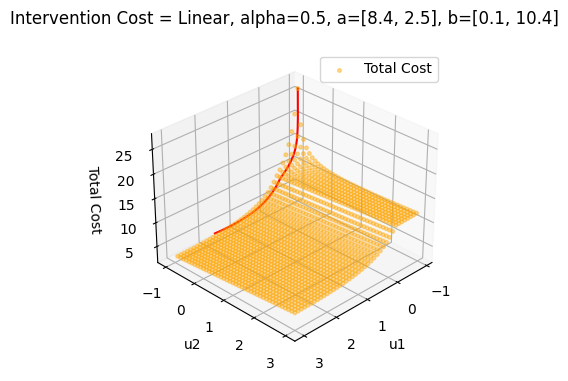

Optimal u=[ 1.74974386 -0.99998598]


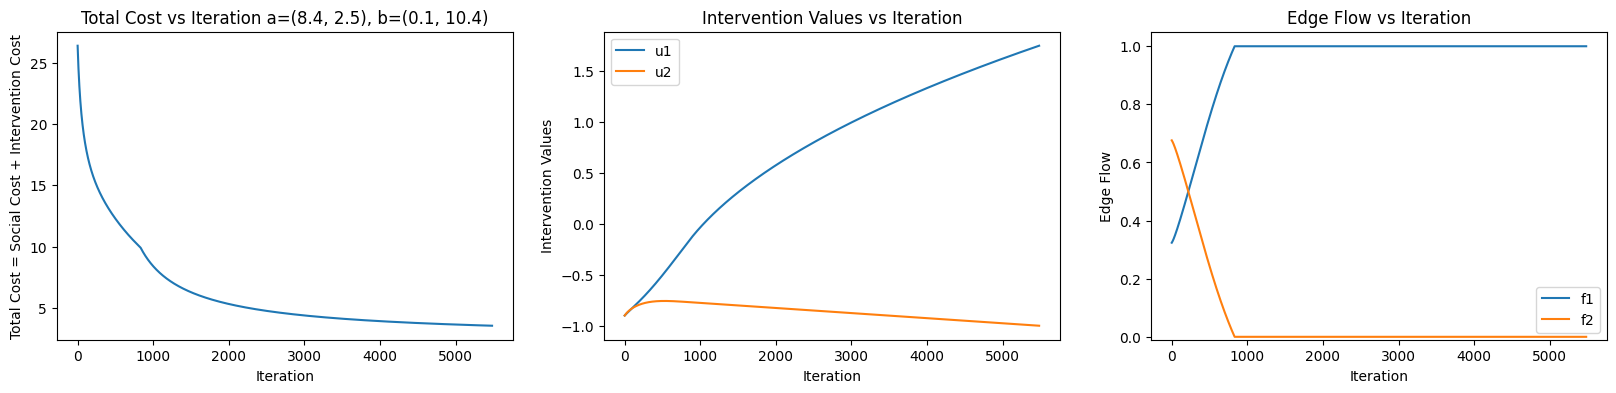

In [16]:
best_u = optimize_2links(m=1, a=[8.4, 2.5], b=[0.1, 10.4], I_cost_def=I_cost_def, lr=0.0001, n_iter=1e4)
print(f'Optimal u={best_u}')

# Linear Intervention Cost, alpha=1

In [17]:
I_cost_def = {'I_cost': lambda u: u,
              'dI_cost': lambda u: 1,
              'alpha': 1, 
              'I_cost_name': 'Linear'}

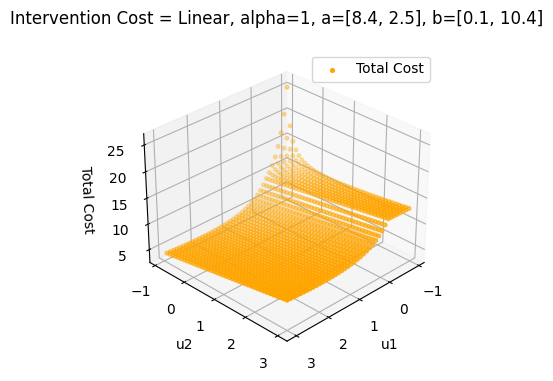

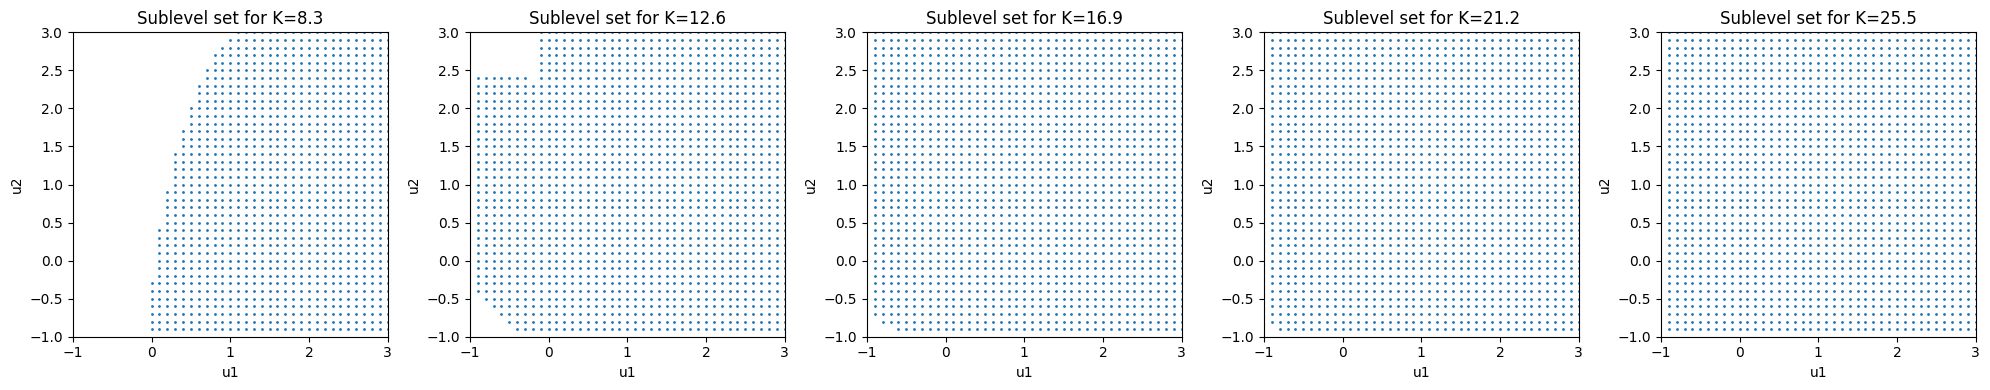

In [18]:
u1, u2, T = sketch_cost(m=1, a=[8.4, 2.5], b=[0.1, 10.4], n_levels=5, I_cost_def = I_cost_def)

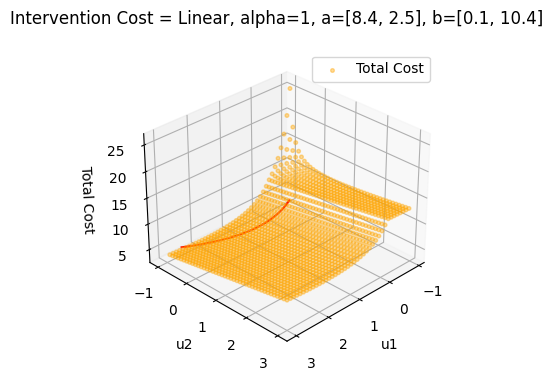

Optimal u=[ 2.55146628 -1.        ]


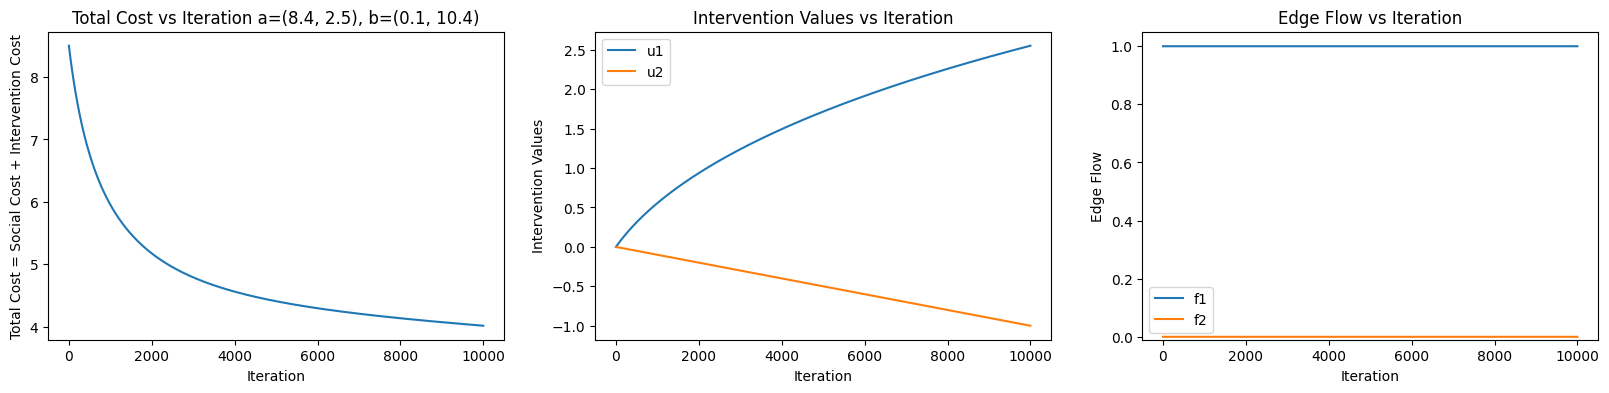

In [19]:
best_u = optimize_2links(m=1, a=[8.4, 2.5], b=[0.1, 10.4], I_cost_def=I_cost_def, lr=0.0001, n_iter=1e4, u0=[0,0])
print(f'Optimal u={best_u}')

# Linear Intervention Cost, alpha=2

In [48]:
I_cost_def = {'I_cost': lambda u: u,
              'dI_cost': lambda u: 1,
              'alpha': 2, 
              'I_cost_name': 'Linear'}

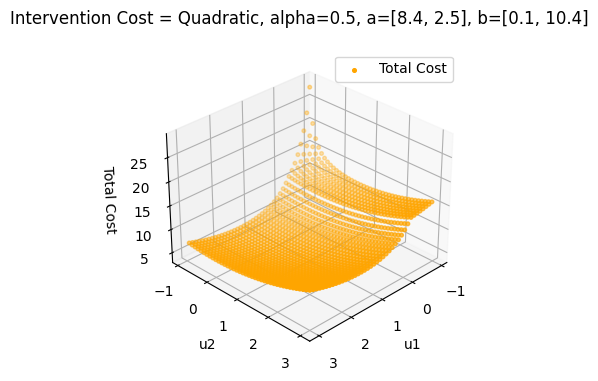

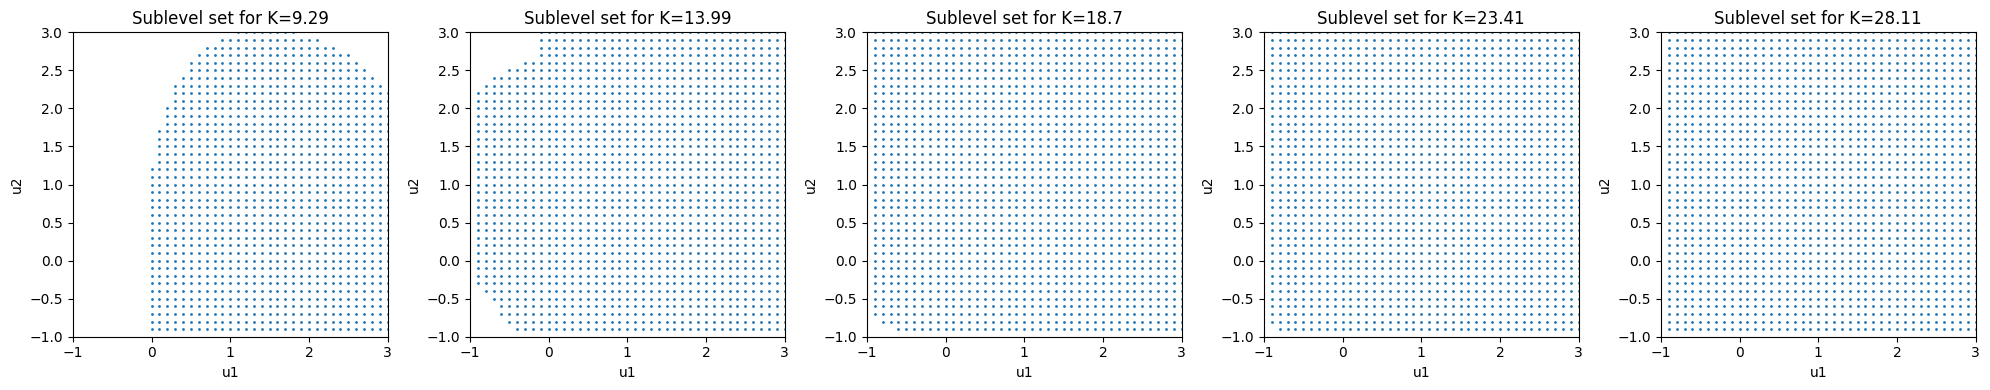

In [34]:
u1, u2, T = sketch_cost(m=1, a=[8.4, 2.5], b=[0.1, 10.4], n_levels=5, I_cost_def = I_cost_def)

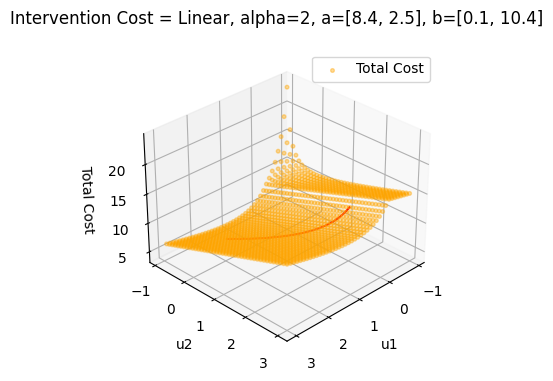

Optimal u=[1.95091978e+00 1.87635118e-13]


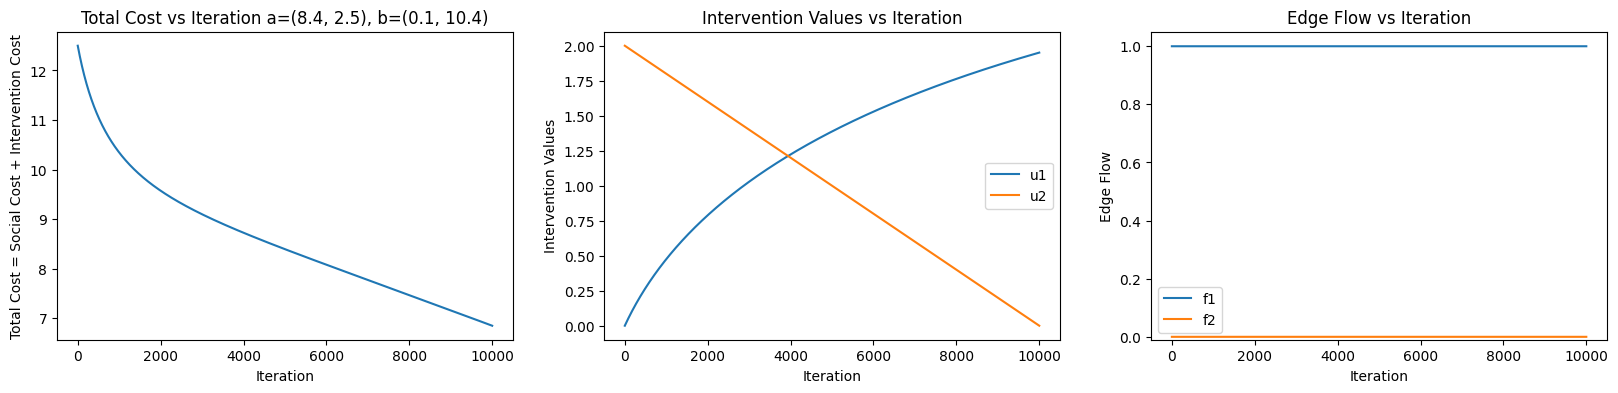

In [24]:
best_u = optimize_2links(m=1, a=[8.4, 2.5], b=[0.1, 10.4], I_cost_def=I_cost_def, lr=0.0001, n_iter=1e4, u0=[0,2])
print(f'Optimal u={best_u}')

### Case where optimization goes wrong

Initial point: [-0.9, 3]


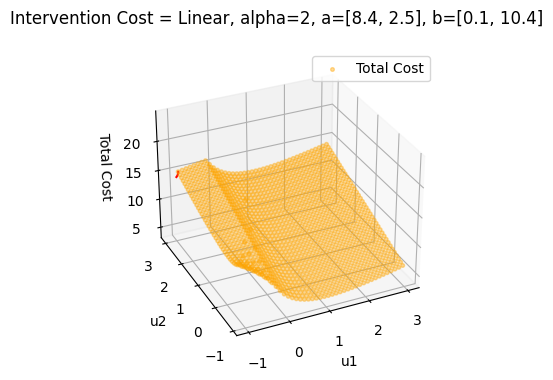

Optimal u=[-0.99815882  2.87443497]


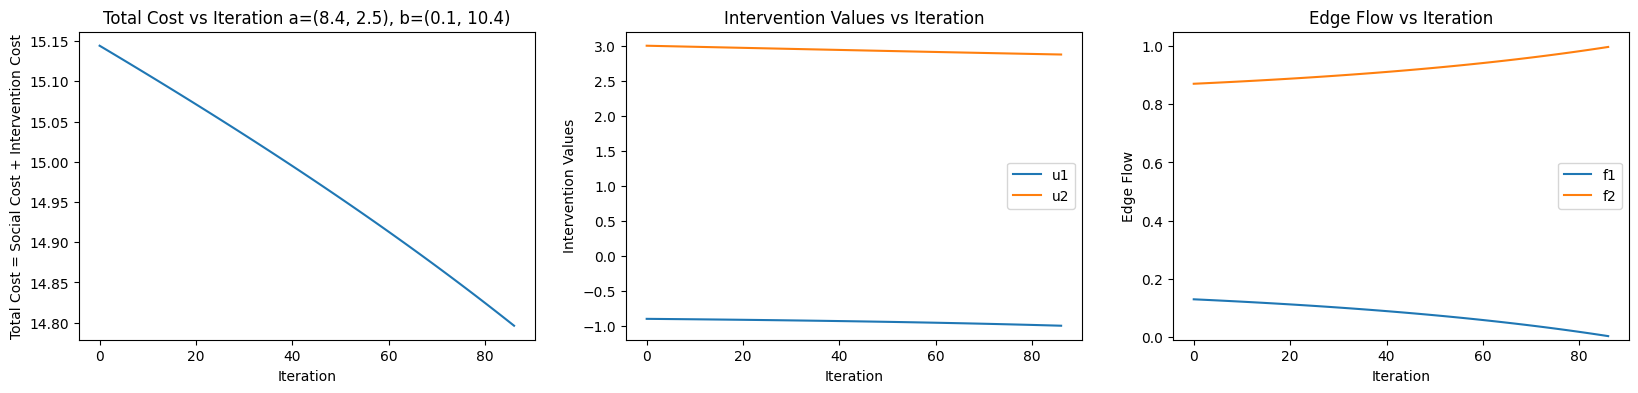

In [49]:
u0 = [-0.9, 3]
print(f'Initial point: {u0}')
best_u = optimize_2links(m=1, a=[8.4, 2.5], b=[0.1, 10.4], I_cost_def=I_cost_def, lr=0.001, n_iter=1e4, u0=u0, elev=30, azim=245, roll=0)
print(f'Optimal u={best_u}')

Initial point: [-0.8, 3]


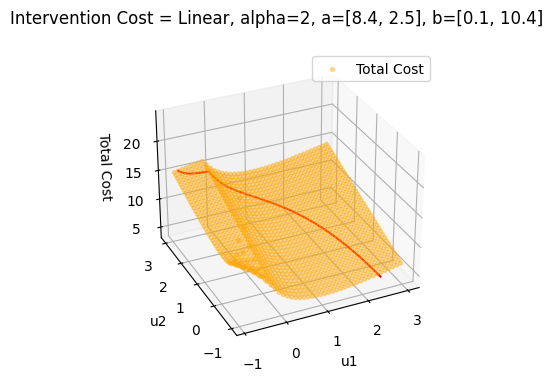

Optimal u=[ 2.4424385  -0.99991168]


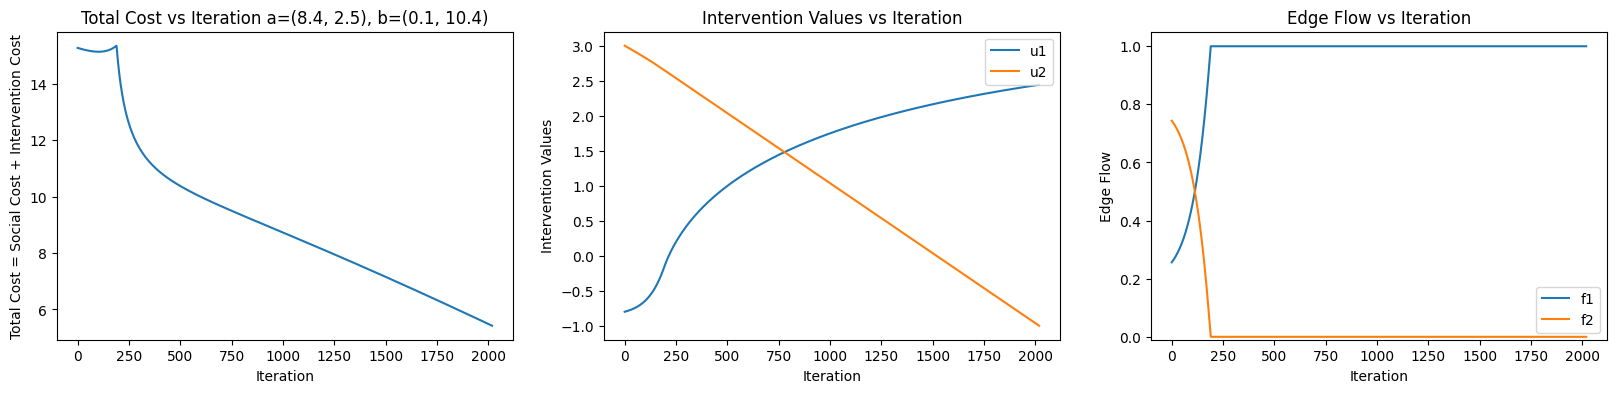

In [50]:
u0 = [-0.8, 3]
print(f'Initial point: {u0}')
best_u = optimize_2links(m=1, a=[8.4, 2.5], b=[0.1, 10.4], I_cost_def=I_cost_def, lr=0.001, n_iter=1e4, u0=u0, elev=30, azim=245, roll=0)
print(f'Optimal u={best_u}')

# Linear Intervention Cost, alpha=20

In [25]:
I_cost_def = {'I_cost': lambda u: u,
              'dI_cost': lambda u: 1,
              'alpha': 20, 
              'I_cost_name': 'Linear'}

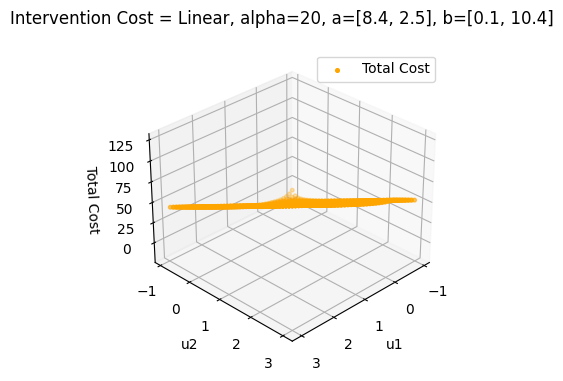

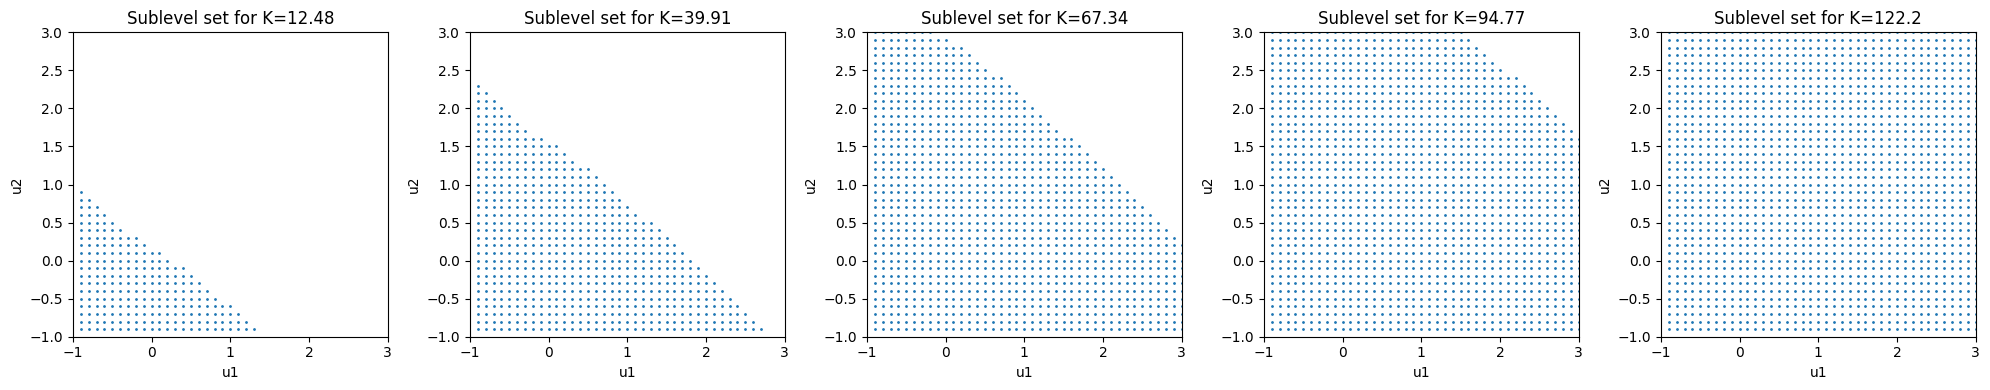

In [26]:
u1, u2, T = sketch_cost(m=1, a=[8.4, 2.5], b=[0.1, 10.4], n_levels=5, I_cost_def = I_cost_def)

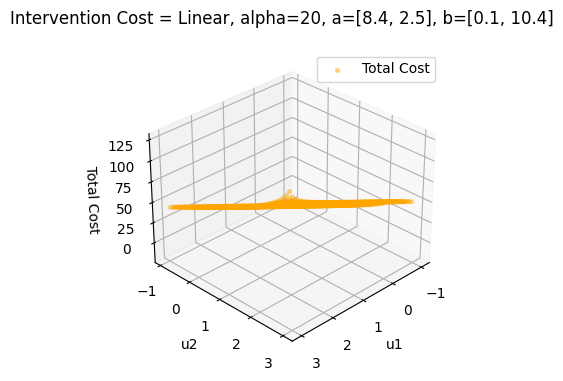

Optimal u=[-0.99962114  0.49799172]


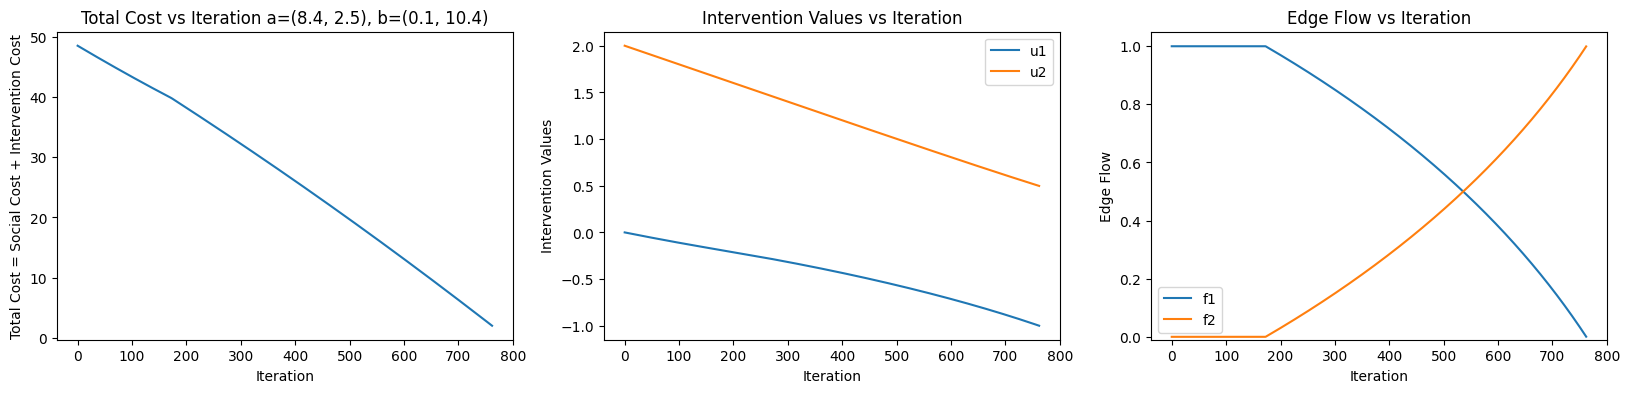

In [27]:
best_u = optimize_2links(m=1, a=[8.4, 2.5], b=[0.1, 10.4], I_cost_def=I_cost_def, lr=0.0001, n_iter=1e4, u0=[0,2])
print(f'Optimal u={best_u}')

# Quadratic Intervention Cost, alpha=0.5

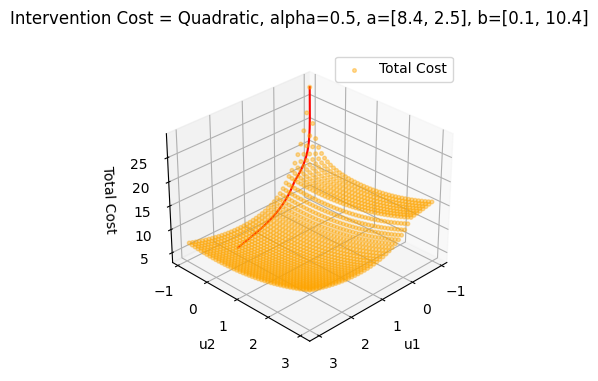

Optimal u=[ 2.06914247 -0.27548539]


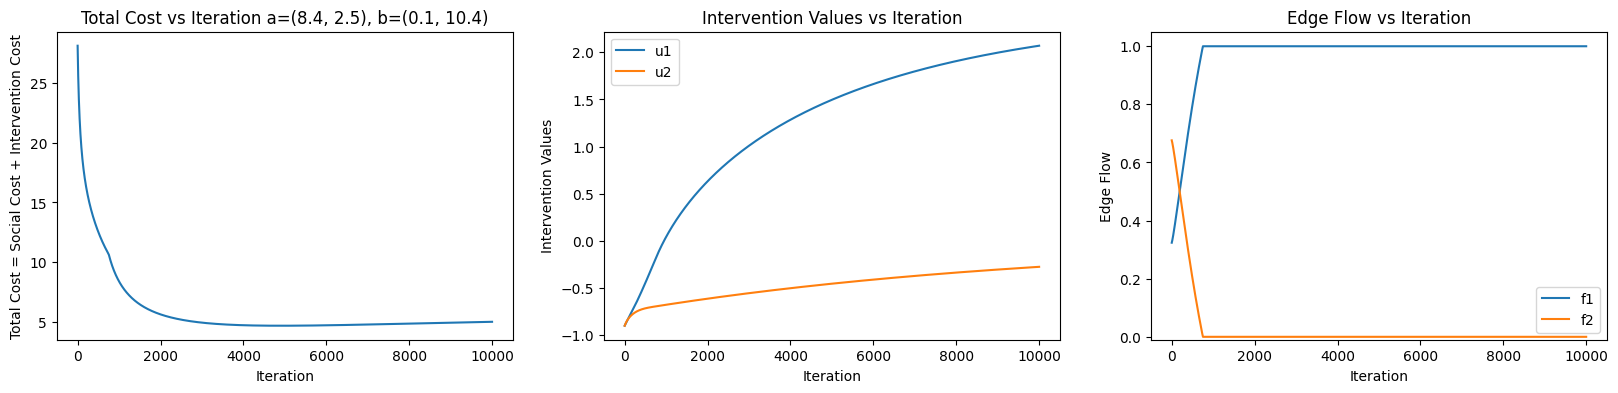

In [28]:
I_cost_def = {'I_cost': lambda u: u**2,
              'dI_cost': lambda u: 2*u,
              'alpha': 0.5, 
              'I_cost_name': 'Quadratic'}

best_u = optimize_2links(m=1, a=[8.4, 2.5], b=[0.1, 10.4], I_cost_def=I_cost_def, lr=0.0001, n_iter=1e4)
print(f'Optimal u={best_u}')

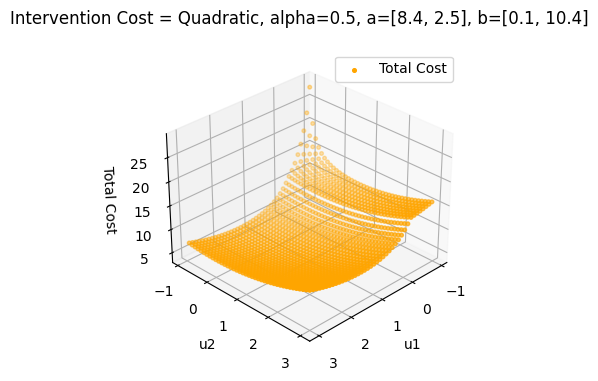

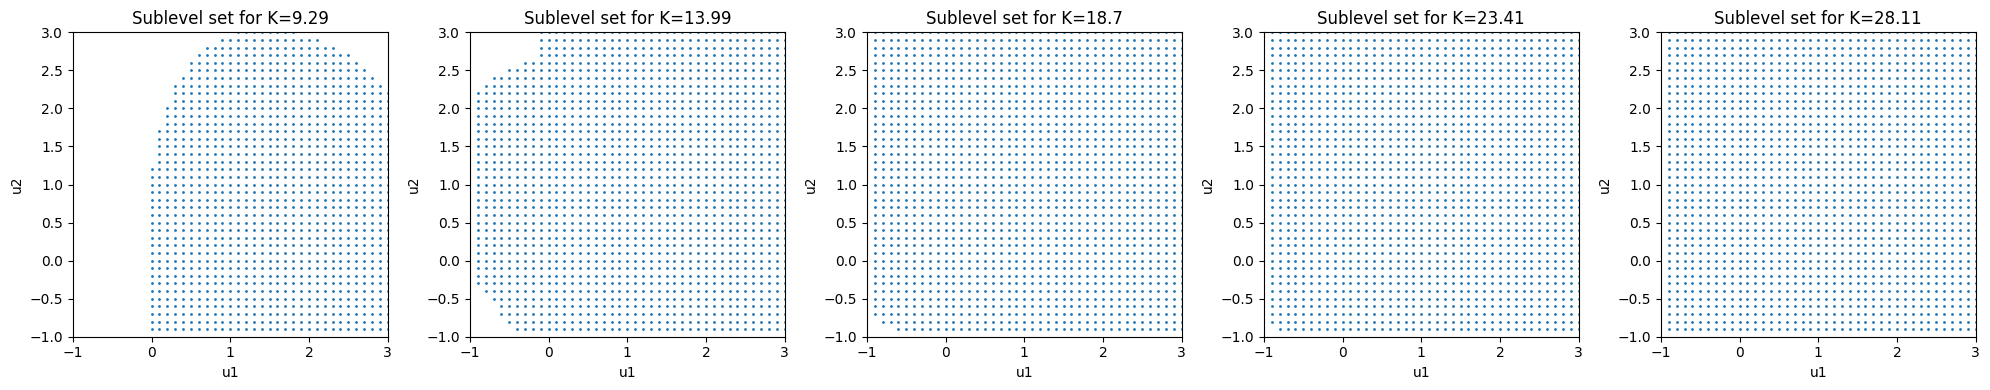

In [32]:
u1, u2, T = sketch_cost(m=1, a=[8.4, 2.5], b=[0.1, 10.4], n_levels=5, I_cost_def = I_cost_def)

# Quadratic Intervention Cost, alpha=1

In [35]:
I_cost_def = {'I_cost': lambda u: u**2,
              'dI_cost': lambda u: 2*u,
              'alpha': 1, 
              'I_cost_name': 'Quadratic'}

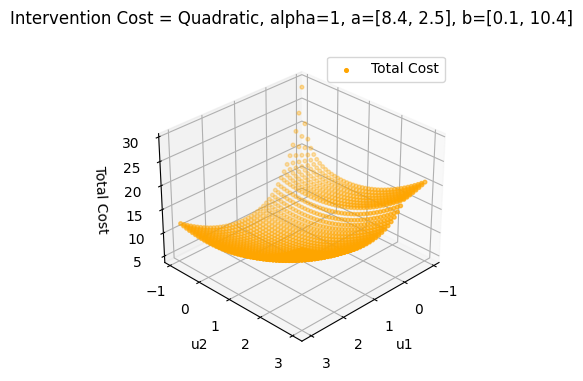

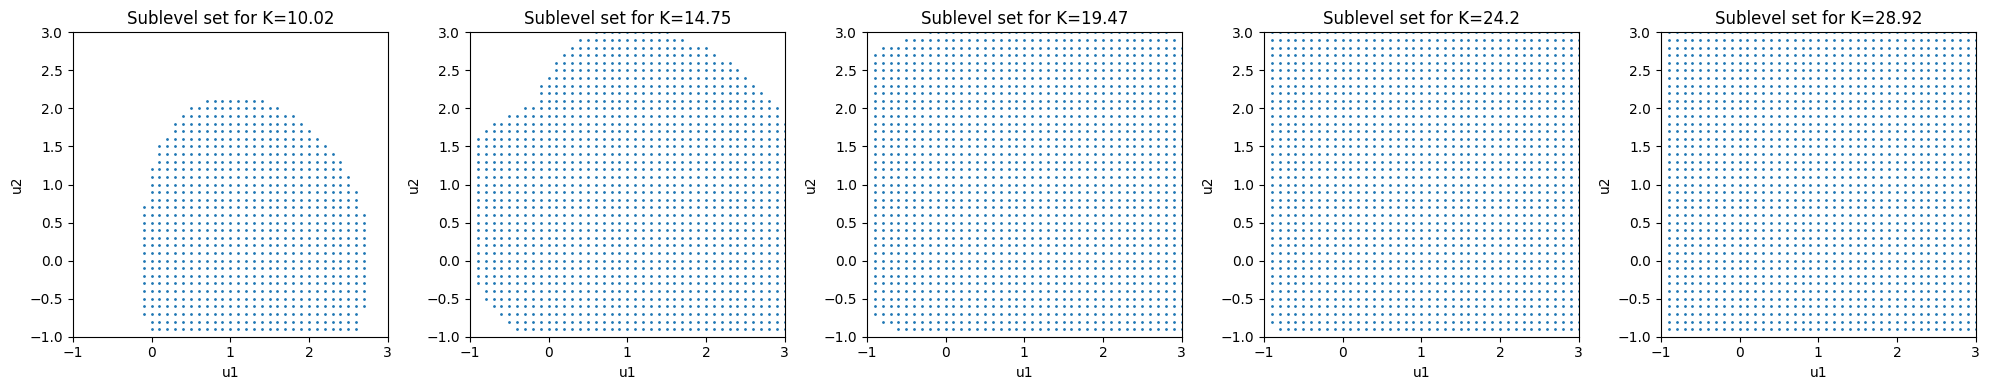

In [36]:
u1, u2, T = sketch_cost(m=1, a=[8.4, 2.5], b=[0.1, 10.4], n_levels=5, I_cost_def = I_cost_def)

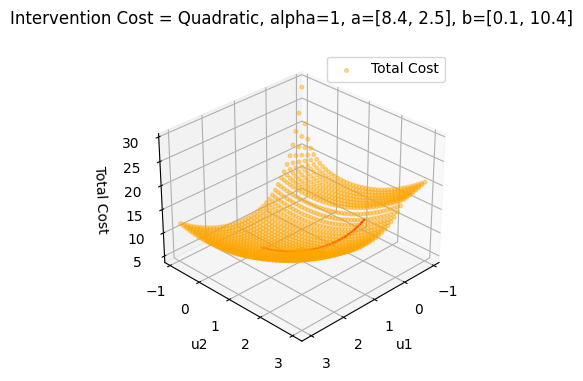

Optimal u=[1.5620315  0.27061643]


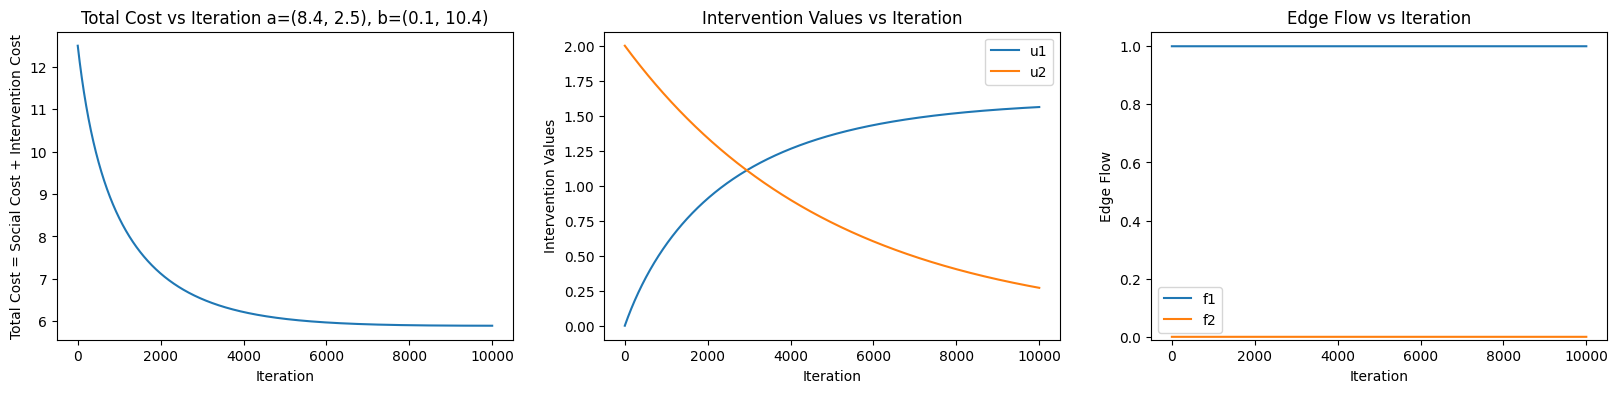

In [37]:
best_u = optimize_2links(m=1, a=[8.4, 2.5], b=[0.1, 10.4], I_cost_def=I_cost_def, lr=0.0001, n_iter=1e4, u0=[0,2])
print(f'Optimal u={best_u}')

# Quadratic Intervention Cost, alpha = 2

In [44]:
I_cost_def = {'I_cost': lambda u: u**2,
              'dI_cost': lambda u: 2*u,
              'alpha': 2, 
              'I_cost_name': 'Quadratic'}

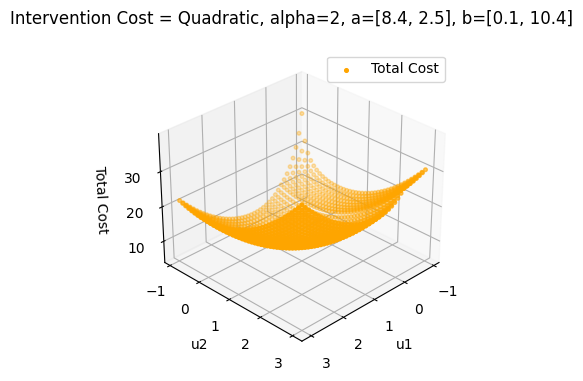

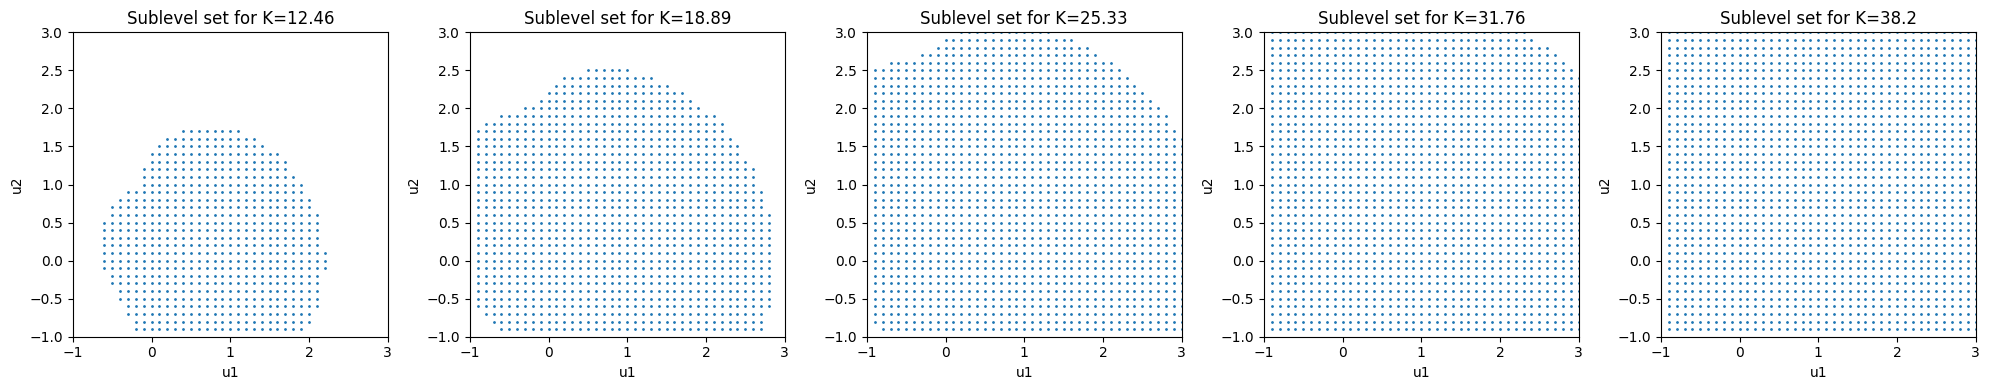

In [45]:
u1, u2, T = sketch_cost(m=1, a=[8.4, 2.5], b=[0.1, 10.4], n_levels=5, I_cost_def = I_cost_def)

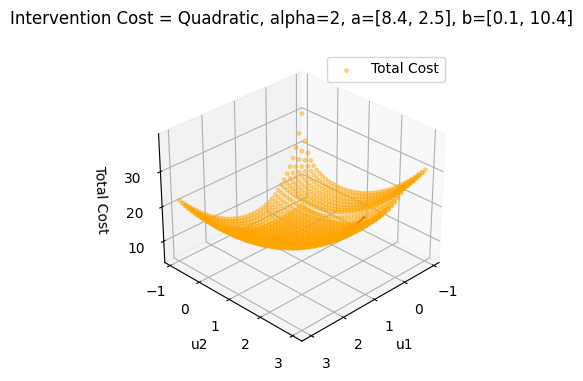

Optimal u=[1.03096253 0.03660198]


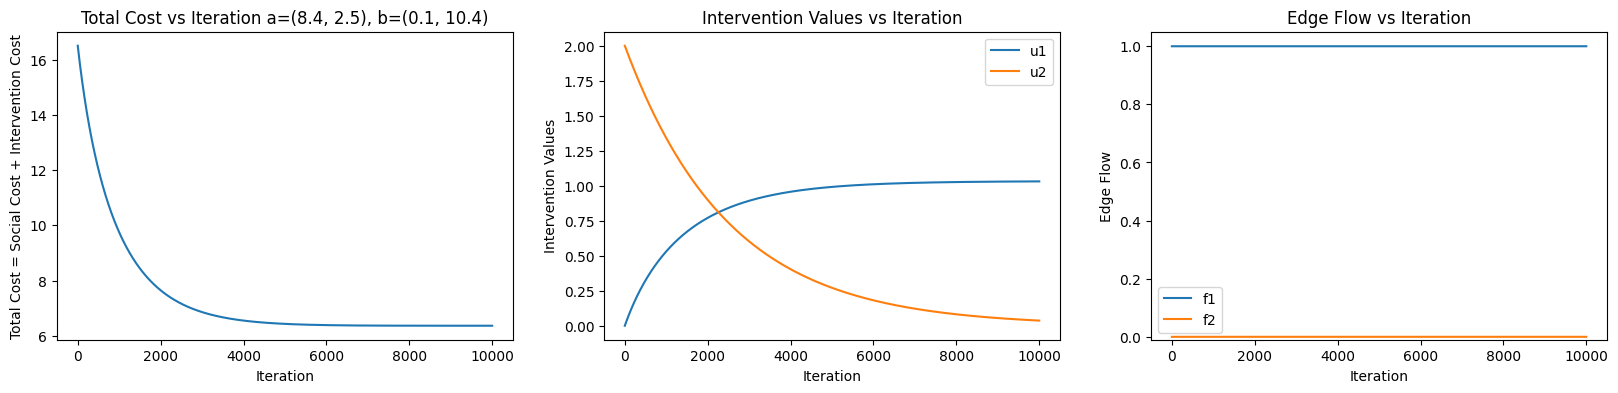

In [40]:
best_u = optimize_2links(m=1, a=[8.4, 2.5], b=[0.1, 10.4], I_cost_def=I_cost_def, lr=0.0001, n_iter=1e4, u0=[0,2])
print(f'Optimal u={best_u}')

# Quadratic Intervention Cost, alpha = 20

In [41]:
I_cost_def = {'I_cost': lambda u: u**2,
              'dI_cost': lambda u: 2*u,
              'alpha': 20, 
              'I_cost_name': 'Quadratic'}

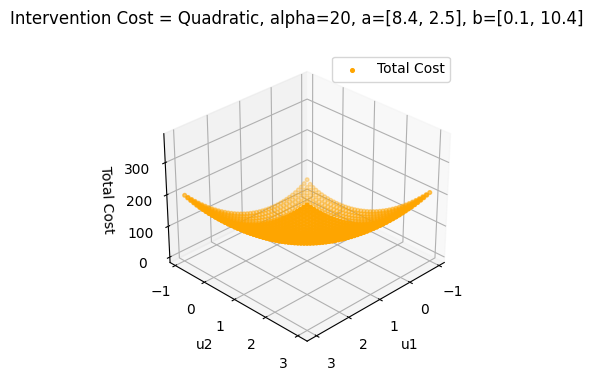

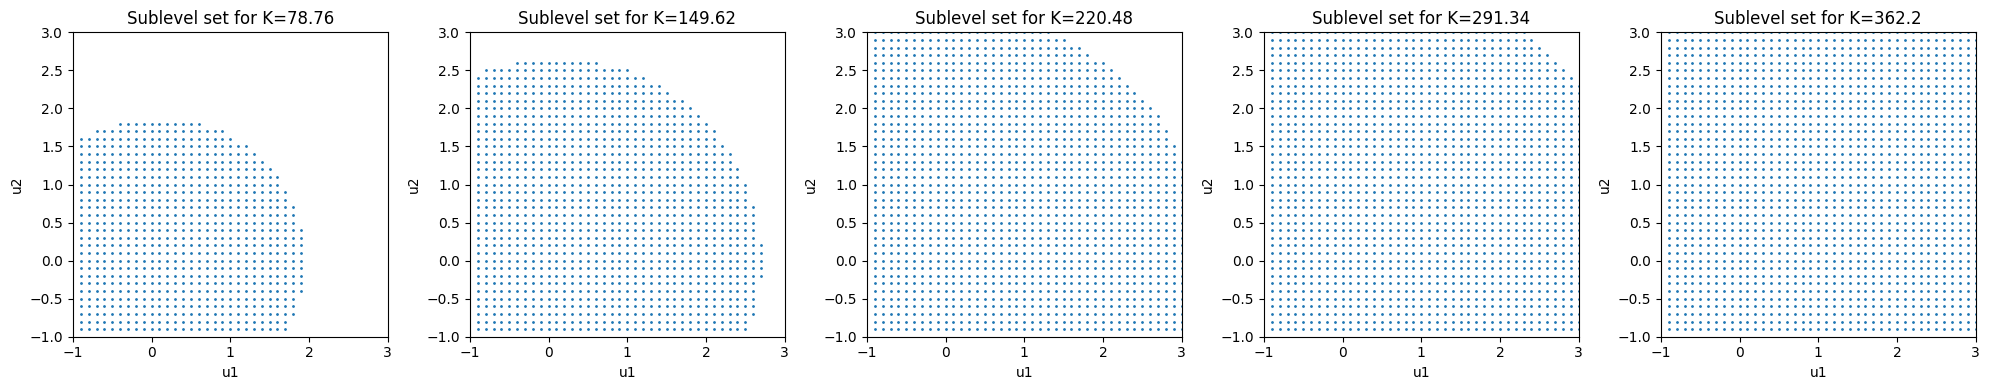

In [42]:
u1, u2, T = sketch_cost(m=1, a=[8.4, 2.5], b=[0.1, 10.4], n_levels=5, I_cost_def = I_cost_def)

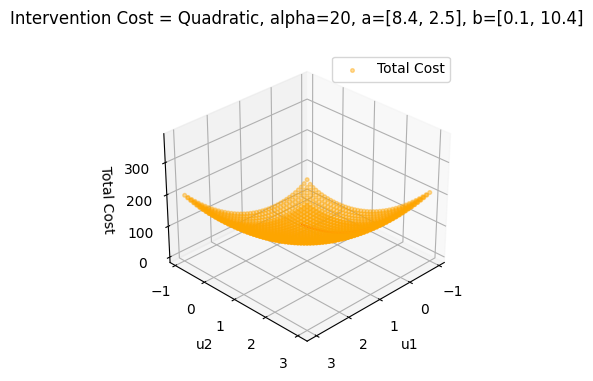

Optimal u=[1.78232998e-01 7.84177239e-18]


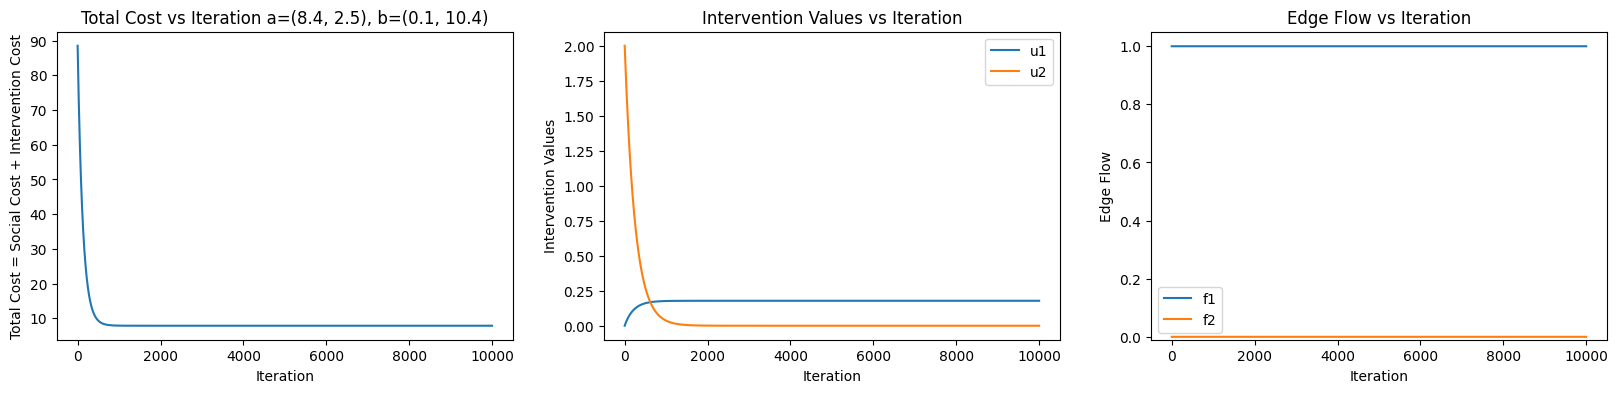

In [43]:
best_u = optimize_2links(m=1, a=[8.4, 2.5], b=[0.1, 10.4], I_cost_def=I_cost_def, lr=0.0001, n_iter=1e4, u0=[0,2])
print(f'Optimal u={best_u}')